# Predict the Credit_Mix category for a customer based on their financial data, and provide actionable insights to improve credit health.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/Bank%20Data.csv'
df = pd.read_csv(url)
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


In [4]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

In [5]:
df.shape

(50000, 27)

# Project Workflow

In order to do this project, must follow this structure....

## 1. Data Preprocessing
- Handle missing and invalid values in the dataset.
- Encode categorical variables appropriately.
- Scale and normalize numeric features for uniformity.
- Detect and address outliers to improve model stability.

In [6]:
#replace invalid values ​​with NaN
invalid_values = ['_', '_______', '!@9#%8', 'NM', '#F%$D@*&8', 'NA', '']
for col in df.columns:
    df[col] = df[col].replace(invalid_values, np.nan)

In [7]:
#identify and convert numeric columns
numeric_cols = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
    'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
    'Amount_invested_monthly', 'Monthly_Balance']

for col in numeric_cols:
  df[col] = pd.to_numeric(df[col], errors='coerce')

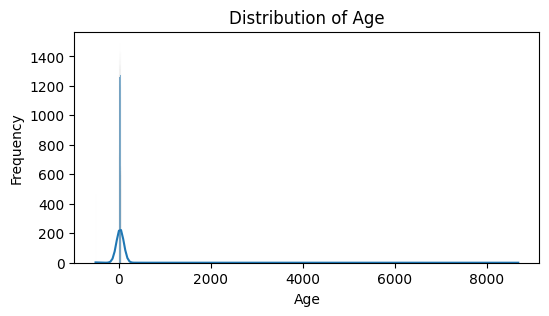

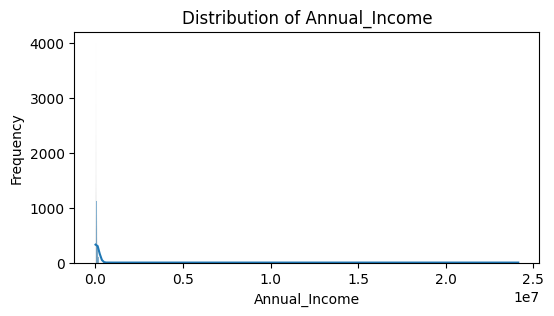

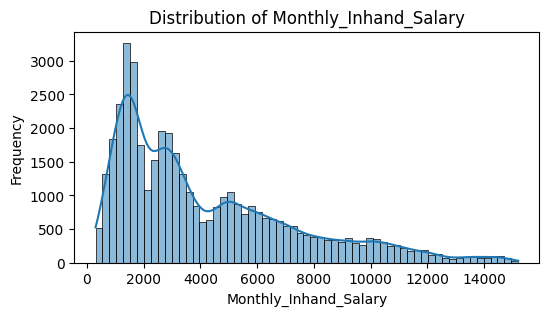

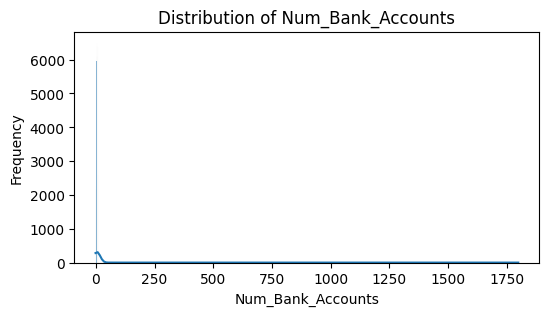

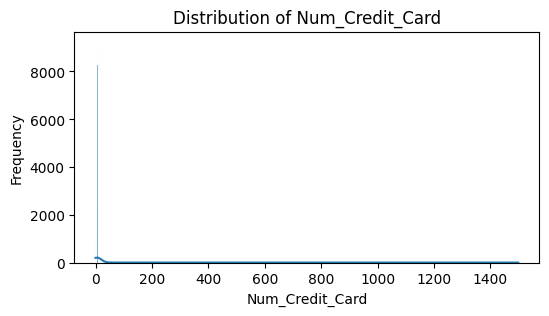

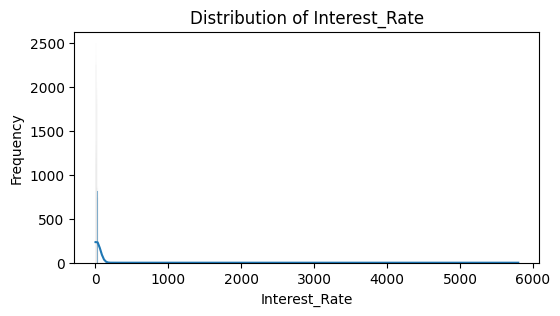

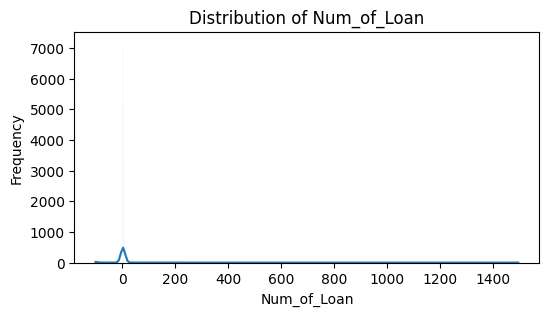

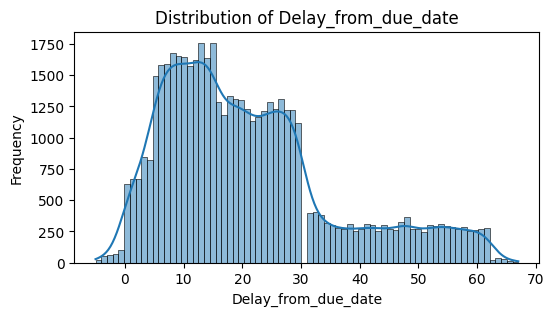

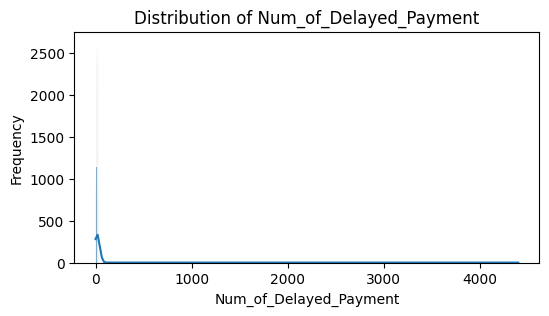

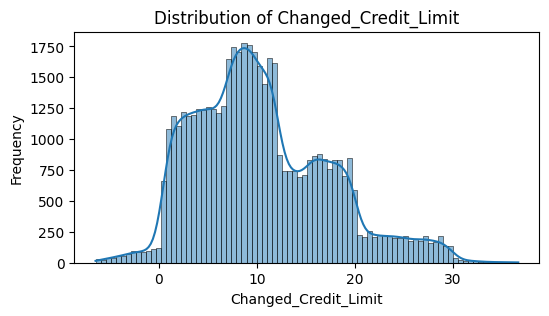

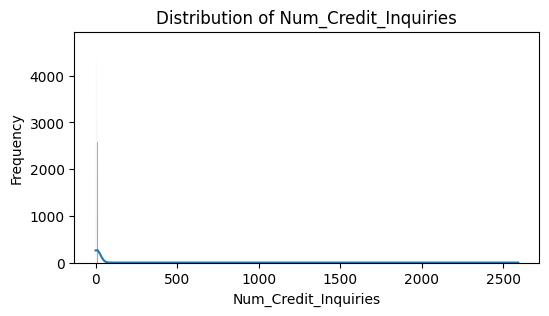

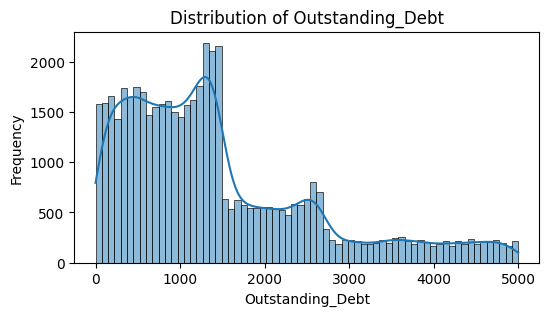

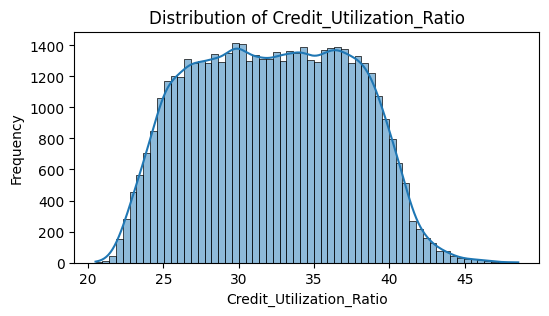

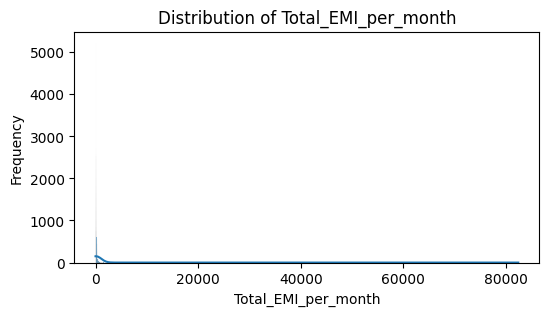

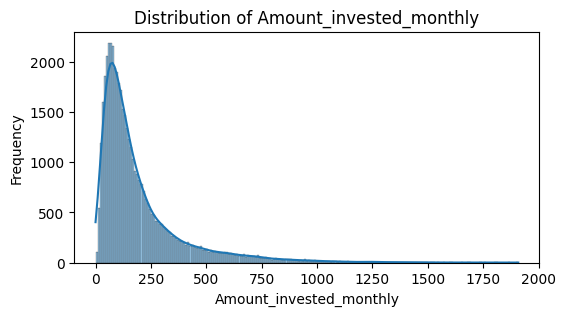

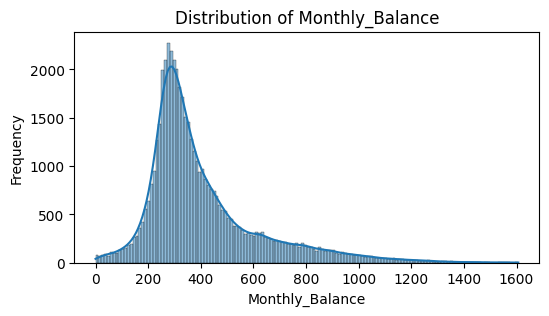

In [8]:
#numeric column distribution

for col in numeric_cols:
    if col in df.columns:
        plt.figure(figsize=(6, 3))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

In [9]:
#Convert Credit_History_Age to months
def parse_credit_history_age(age_str):
    if pd.isna(age_str):
        return np.nan
    try:
        parts = age_str.split()
        years = int(parts[0])
        months = int(parts[3]) if len(parts) > 3 else 0
        return years * 12 + months
    except:
        return np.nan

df['Credit_History_Age_Months'] = df['Credit_History_Age'].apply(parse_credit_history_age)
numeric_cols.append('Credit_History_Age_Months')

In [10]:
#impute missing values: numeric - median, categorical - mode
for col in numeric_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

categorical_cols = [
    'Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour'
]

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [11]:
#Type_of_Loan Create dummy
if 'Type_of_Loan' in df.columns:
    df['Type_of_Loan'] = df['Type_of_Loan'].fillna('No Loan')
    loan_types = df['Type_of_Loan'].str.split(', ').explode().unique()
    for loan in loan_types:
        if loan and loan != 'and':
            df[f'Loan_{loan.strip()}'] = df['Type_of_Loan'].apply(lambda x: 1 if loan in x else 0)

In [12]:
df.shape

(50000, 47)

In [13]:
#Drop unnecessary columns
drop_cols = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Type_of_Loan', 'Credit_History_Age']
df.drop(columns=drop_cols, inplace=True)

In [14]:
df.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Loan_Debt Consolidation Loan,Loan_and Auto Loan,Loan_and Payday Loan,Loan_Payday Loan,Loan_Student Loan,Loan_and Personal Loan,Loan_Home Equity Loan,Loan_Mortgage Loan,Loan_and Debt Consolidation Loan,Loan_and Credit-Builder Loan
0,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,3,7.0,...,0,0,0,0,0,0,1,0,0,0
1,24.0,Scientist,19114.12,1824.843333,3,4,3,4.0,3,9.0,...,0,0,0,0,0,0,1,0,0,0
2,24.0,Scientist,19114.12,1824.843333,3,4,3,4.0,-1,4.0,...,0,0,0,0,0,0,1,0,0,0
3,34.0,Scientist,19114.12,3086.305000,3,4,3,4.0,4,5.0,...,0,0,0,0,0,0,1,0,0,0
4,28.0,Lawyer,34847.84,3037.986667,2,4,6,1.0,3,1.0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df.shape

(50000, 40)

In [16]:
#outlier handle
df['Age'] = df['Age'].clip(18, 100)

In [17]:
#Clip outliers with IQR for other numeric columns
for col in numeric_cols:
    if col in df.columns and col != 'Age':
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)

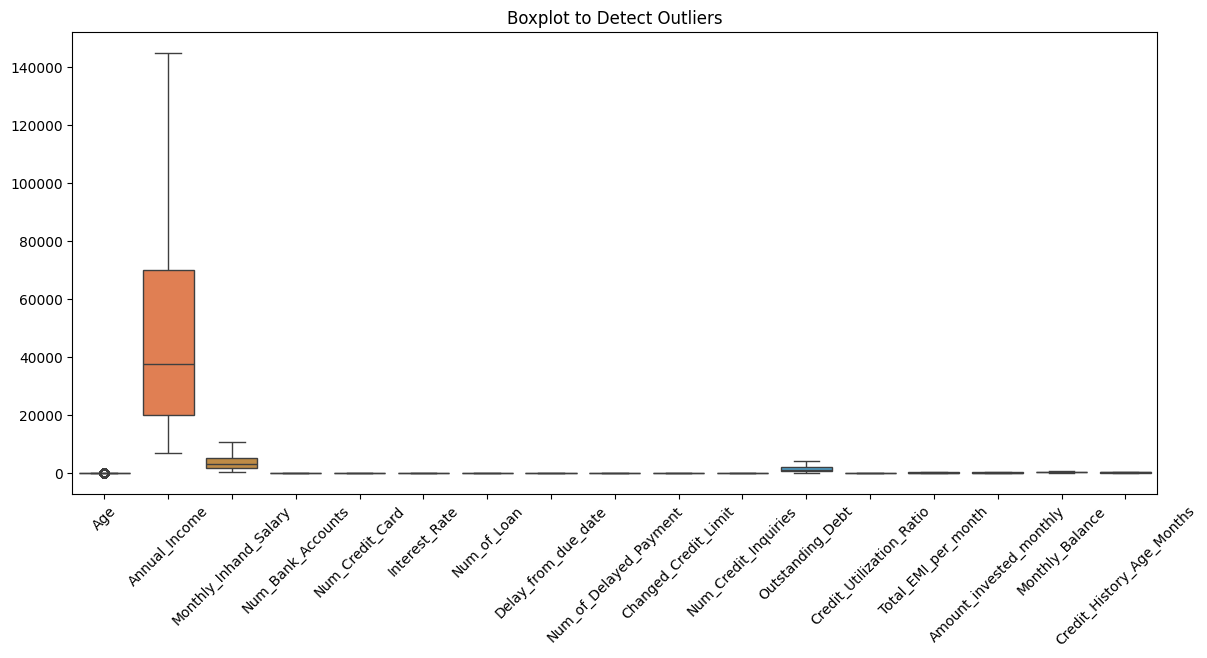

In [18]:
#Boxplot for Outlie
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=45)
plt.title("Boxplot to Detect Outliers")
plt.show()


In [19]:
#Categorical Encode and Numeric Scale
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)])

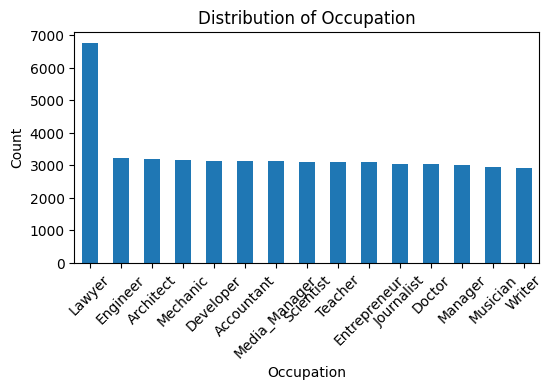

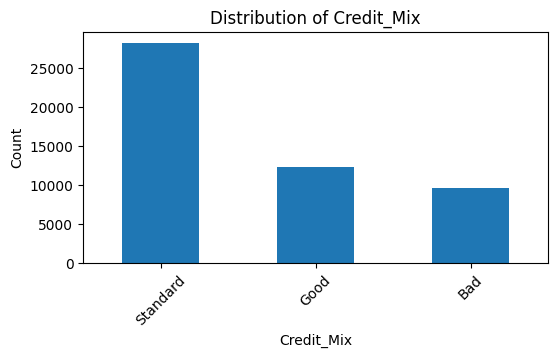

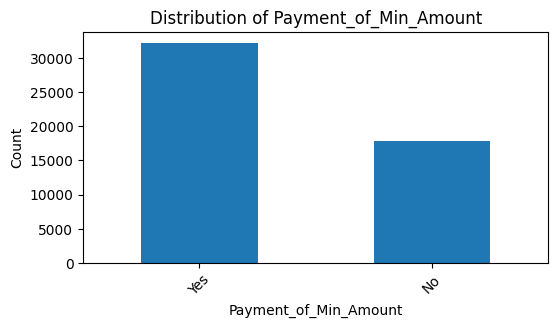

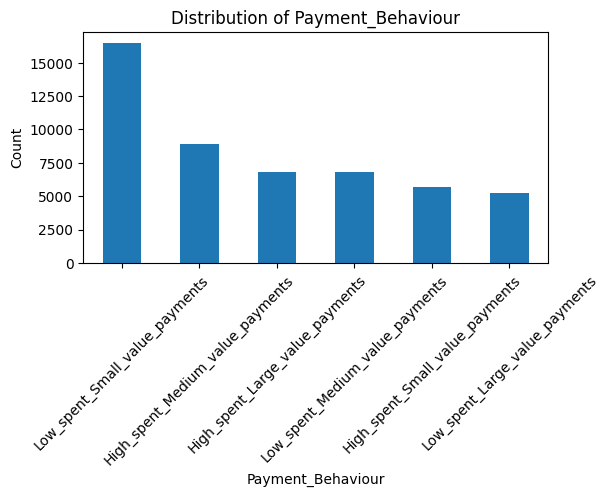

In [20]:
#categorical Distribution

for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(6, 3))
        df[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

In [21]:
df.columns

Index(['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Payment_of_Min_Amount',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour',
       'Monthly_Balance', 'Credit_History_Age_Months', 'Loan_Auto Loan',
       'Loan_Credit-Builder Loan', 'Loan_Personal Loan',
       'Loan_and Home Equity Loan', 'Loan_and Not Specified',
       'Loan_Not Specified', 'Loan_No Loan', 'Loan_and Mortgage Loan',
       'Loan_and Student Loan', 'Loan_Debt Consolidation Loan',
       'Loan_and Auto Loan', 'Loan_and Payday Loan', 'Loan_Payday Loan',
       'Loan_Student Loan', 'Loan_and Personal Loan', 'Loan_Home Equity Loan',
       'Loan_Mortgage Loan', 'Loan_and Debt Consolidation Loan',
       'Loan_and Credit-

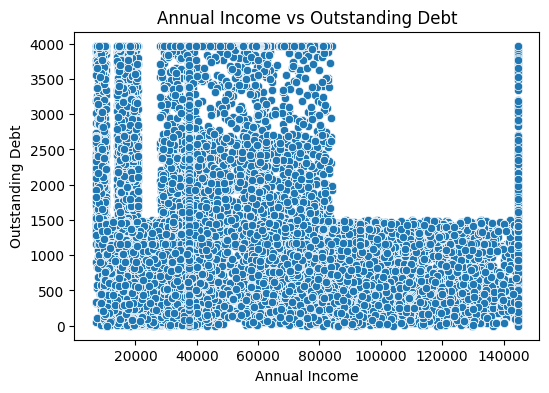

In [22]:
#Income vs Outstanding Debt
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df['Annual_Income'], y=df['Outstanding_Debt'])
plt.title("Annual Income vs Outstanding Debt")
plt.xlabel("Annual Income")
plt.ylabel("Outstanding Debt")
plt.show()

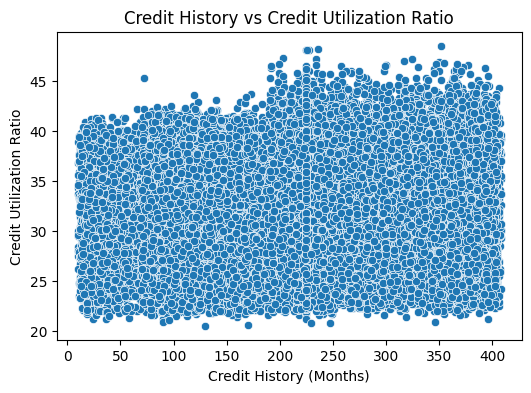

In [23]:
#Credit Utilization vs Credit History
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=df['Credit_History_Age_Months'],
    y=df['Credit_Utilization_Ratio'])
plt.title("Credit History vs Credit Utilization Ratio")
plt.xlabel("Credit History (Months)")
plt.ylabel("Credit Utilization Ratio")
plt.show()

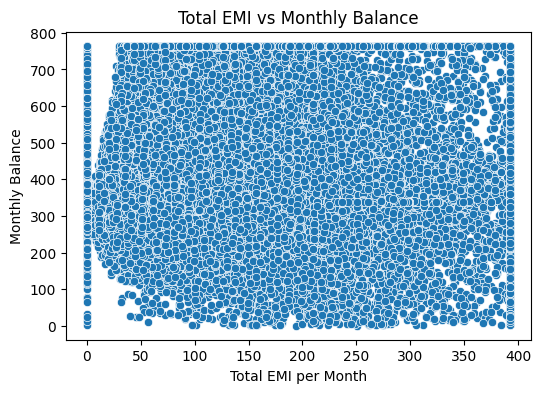

In [24]:
#EMI vs Monthly Balance
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=df['Total_EMI_per_month'],
    y=df['Monthly_Balance'])
plt.title("Total EMI vs Monthly Balance")
plt.xlabel("Total EMI per Month")
plt.ylabel("Monthly Balance")
plt.show()

In [25]:
#preprocessed data
processed_data = preprocessor.fit_transform(df)
#preprocessed data save csv format
df.to_csv('preprocessed_bank_data.csv', index=False)

## 2. Exploratory Data Analysis (EDA)
- Perform descriptive statistics to understand the data distribution.
- Visualize relationships between features and the target variable.
- Analyze correlations and identify trends or anomalies in the data.

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('preprocessed_bank_data.csv')

#target map
df['Credit_Mix_Num'] = df['Credit_Mix'].map({'Bad': 0, 'Standard': 1, 'Good': 2})


In [27]:
df.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Loan_and Auto Loan,Loan_and Payday Loan,Loan_Payday Loan,Loan_Student Loan,Loan_and Personal Loan,Loan_Home Equity Loan,Loan_Mortgage Loan,Loan_and Debt Consolidation Loan,Loan_and Credit-Builder Loan,Credit_Mix_Num
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000
mean,34.96922,50057.708820,3942.991306,5.464360,5.673350,14.984960,3.299260,20.882200,13.534230,10.337998,...,0.081760,0.089040,0.319440,0.310400,0.08664,0.314000,0.31360,0.087040,0.085200,1.054080
std,13.53275,36868.360655,2742.343721,2.716667,2.239159,9.241775,2.645329,14.432069,6.164995,6.662301,...,0.274001,0.284804,0.466264,0.462662,0.28131,0.464121,0.46396,0.281896,0.279182,0.658334
min,18.00000,7005.930000,303.645417,-1.000000,0.000000,1.000000,-2.500000,-5.000000,-3.000000,-6.450000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,25.00000,20062.860000,1794.304167,3.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.440000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000
50%,34.00000,37575.870000,3086.305000,6.000000,5.000000,13.000000,3.000000,18.000000,14.000000,9.410000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000
75%,42.00000,69955.560000,5338.967500,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,14.600000,...,0.000000,0.000000,1.000000,1.000000,0.00000,1.000000,1.00000,0.000000,0.000000,1.000000
max,100.00000,144794.610000,10655.962500,13.000000,11.500000,38.000000,9.500000,55.000000,31.500000,28.340000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,2.000000


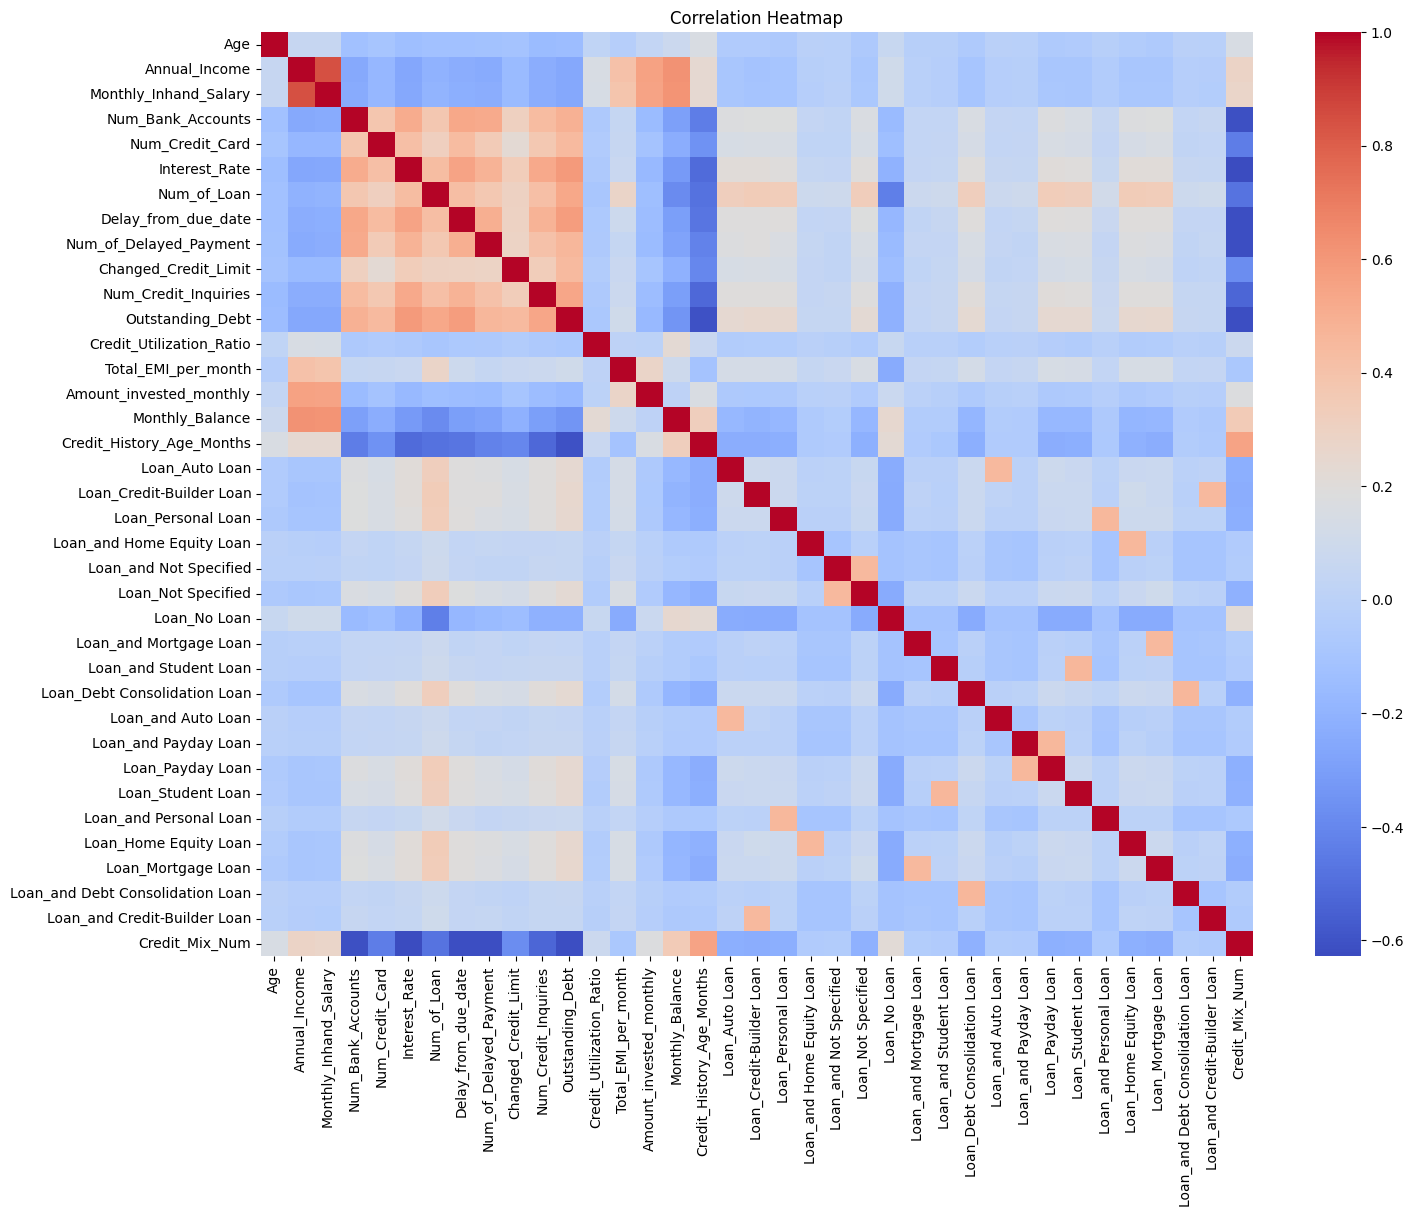

In [28]:
# Correlation Matrix
corr_matrix = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

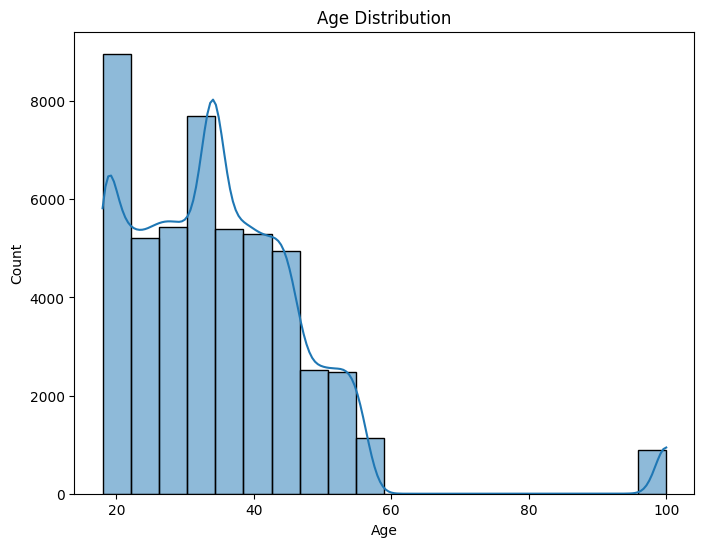

In [29]:
#Distribution Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

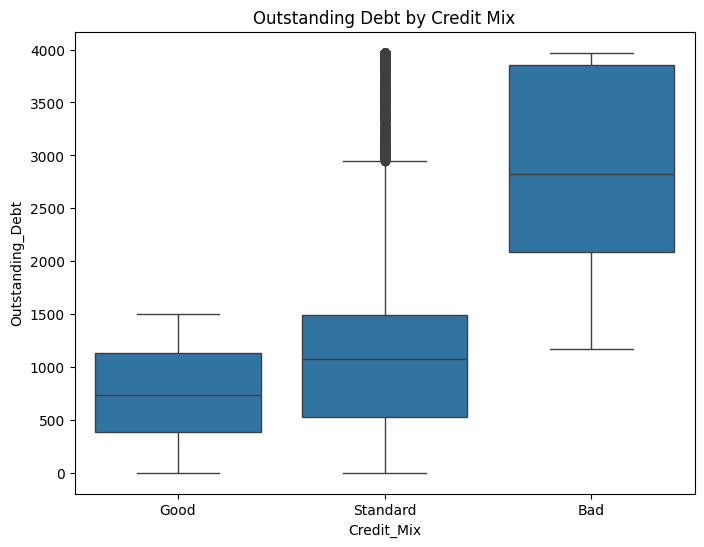

In [30]:
#Outstanding Debt by Credit Mix (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Credit_Mix', y='Outstanding_Debt', data=df)
plt.title('Outstanding Debt by Credit Mix')
plt.show()

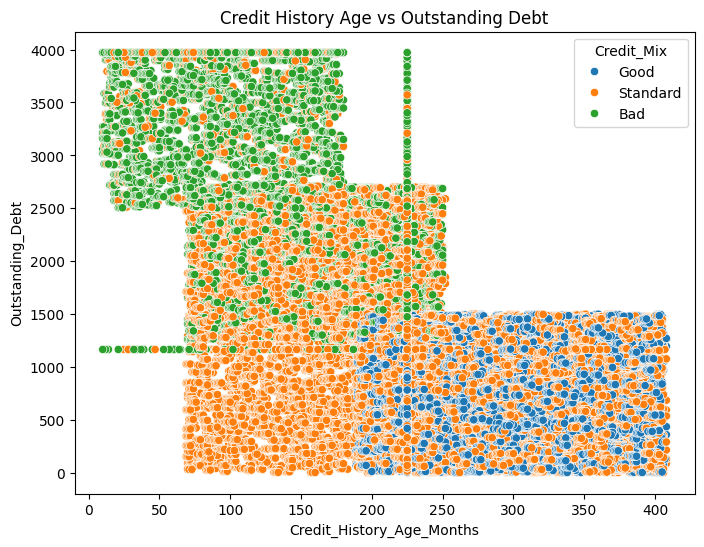

In [31]:
#Credit History Age vs. Debt (Scatter Plot)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Credit_History_Age_Months', y='Outstanding_Debt', hue='Credit_Mix', data=df)
plt.title('Credit History Age vs Outstanding Debt')
plt.show()

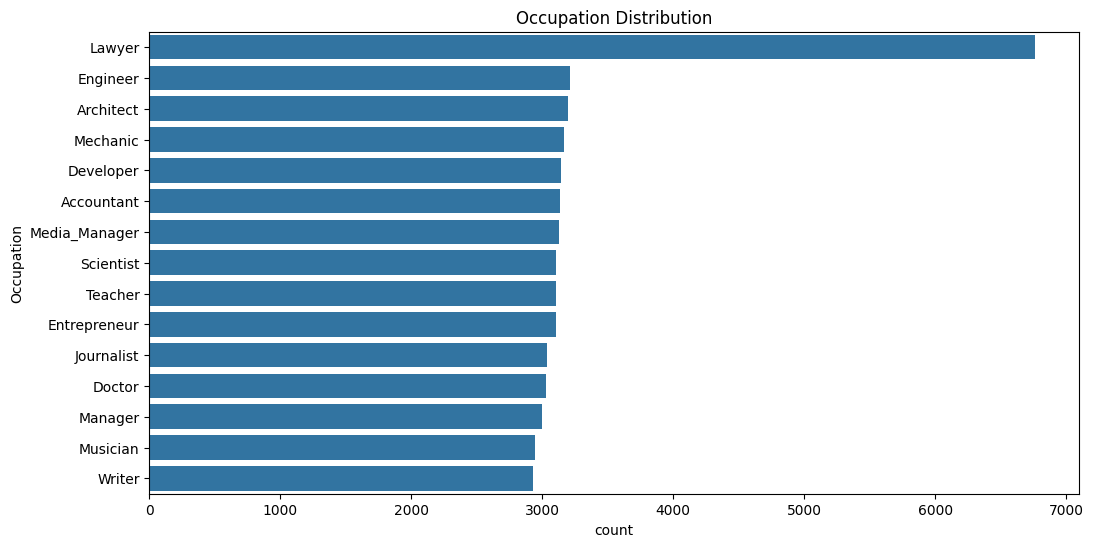

In [32]:
#Occupation Distribution (Bar Plot)
plt.figure(figsize=(12, 6))
sns.countplot(y='Occupation', data=df, order=df['Occupation'].value_counts().index)
plt.title('Occupation Distribution')
plt.show()

## 3. Model Building
- Train multiple machine learning models using the preprocessed data.
- Evaluate the suitability of various models for the task.


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [34]:
df = pd.read_csv('preprocessed_bank_data.csv')
df['Credit_Mix'] = df['Credit_Mix'].map({'Bad': 0, 'Standard': 1, 'Good': 2})

X = df.drop('Credit_Mix', axis=1)
y = df['Credit_Mix']

numeric_cols = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
    'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
    'Amount_invested_monthly', 'Monthly_Balance', 'Credit_History_Age_Months']

categorical_cols = ['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour']

In [35]:
#dummy columns no encoding
loan_cols = [col for col in X.columns if col.startswith('Loan_')]
numeric_cols.extend(loan_cols)

#numeric scale, categorical encode
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)])

In [36]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
#process
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [38]:
#model train
#Logistic Regression
log_reg = LogisticRegression(multi_class='multinomial', max_iter=1000)
log_reg.fit(X_train_processed, y_train)
log_reg_pred = log_reg.predict(X_test_processed)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, log_reg_pred):.4f}")

#Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_processed, y_train)
rf_pred = rf.predict(X_test_processed)
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred):.4f}")

#XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_processed, y_train)
xgb_pred = xgb.predict(X_test_processed)
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")

Logistic Regression Accuracy: 0.8026
Random Forest Accuracy: 0.8607
XGBoost Accuracy: 0.8521


## 4. Model Evaluation
- Compute and plot evaluation metrics for all models, such as accuracy, precision, recall, F1-score, and AUC-ROC.
- Compare the performance of models across multiple metrics.


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score)
from sklearn.preprocessing import label_binarize

In [40]:

#Classification Report all model
print("CLASSIFICATION REPORTS")


models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'XGBoost': xgb}

predictions = {
    'Logistic Regression': log_reg_pred,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred}

for name, pred in predictions.items():
    print(f"\n{name} Report:")
    print(classification_report(y_test, pred,target_names=['Bad', 'Standard', 'Good'],digits=4))

CLASSIFICATION REPORTS

Logistic Regression Report:
              precision    recall  f1-score   support

         Bad     0.7701    0.7849    0.7774      1920
    Standard     0.8319    0.8132    0.8225      5622
        Good     0.7644    0.7921    0.7780      2458

    accuracy                         0.8026     10000
   macro avg     0.7888    0.7967    0.7926     10000
weighted avg     0.8034    0.8026    0.8029     10000


Random Forest Report:
              precision    recall  f1-score   support

         Bad     0.8042    0.9349    0.8646      1920
    Standard     0.9302    0.8132    0.8678      5622
        Good     0.7851    0.9113    0.8435      2458

    accuracy                         0.8607     10000
   macro avg     0.8399    0.8865    0.8587     10000
weighted avg     0.8704    0.8607    0.8612     10000


XGBoost Report:
              precision    recall  f1-score   support

         Bad     0.7896    0.9187    0.8493      1920
    Standard     0.9241    0.8029    

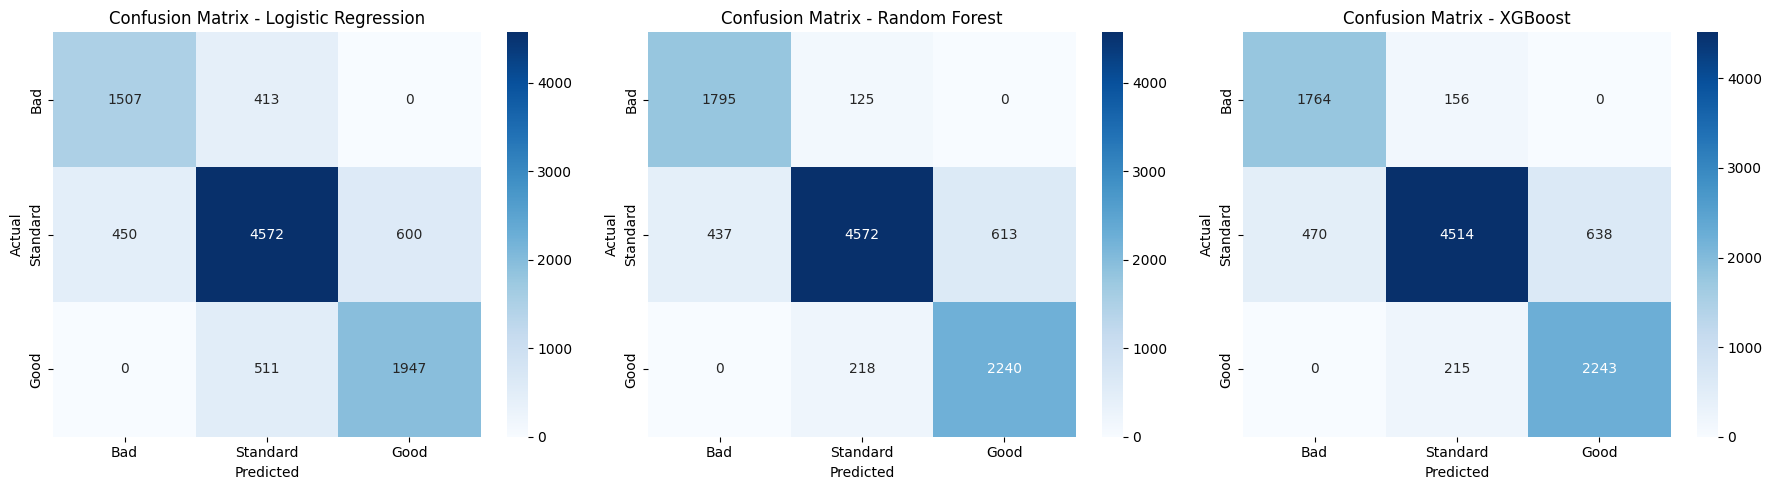

In [41]:
#Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (name, pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Bad', 'Standard', 'Good'],
                yticklabels=['Bad', 'Standard', 'Good'],
                ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix - {name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
#ROC-AUC (Multiclass - One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

auc_scores = {}
for name, model in models.items():
    try:
        y_proba = model.predict_proba(X_test_processed)
        auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='macro')
        auc_scores[name] = auc
        print(f"{name} ROC-AUC: {auc:.4f}")
    except:
        print(f"{name} ROC-AUC: N/A")

Logistic Regression ROC-AUC: 0.9259
Random Forest ROC-AUC: 0.9420
XGBoost ROC-AUC: 0.9415


In [43]:
metrics_df = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision (Macro)': [],
    'Recall (Macro)': [],
    'F1-Score (Macro)': [],
    'ROC-AUC': []})

for name, pred in predictions.items():
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, average='macro', zero_division=0)
    rec = recall_score(y_test, pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, pred, average='macro', zero_division=0)
    auc = auc_scores.get(name, 0)

    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Model': [name],
        'Accuracy': [acc],
        'Precision (Macro)': [prec],
        'Recall (Macro)': [rec],
        'F1-Score (Macro)': [f1],
        'ROC-AUC': [auc]
    })], ignore_index=True)


print("MODEL COMPARISON TABLE")
print(metrics_df.round(4))

MODEL COMPARISON TABLE
                 Model  Accuracy  Precision (Macro)  Recall (Macro)  \
0  Logistic Regression    0.8026             0.7888          0.7967   
1        Random Forest    0.8607             0.8399          0.8865   
2              XGBoost    0.8521             0.8307          0.8781   

   F1-Score (Macro)  ROC-AUC  
0            0.7926   0.9259  
1            0.8587   0.9420  
2            0.8496   0.9415  


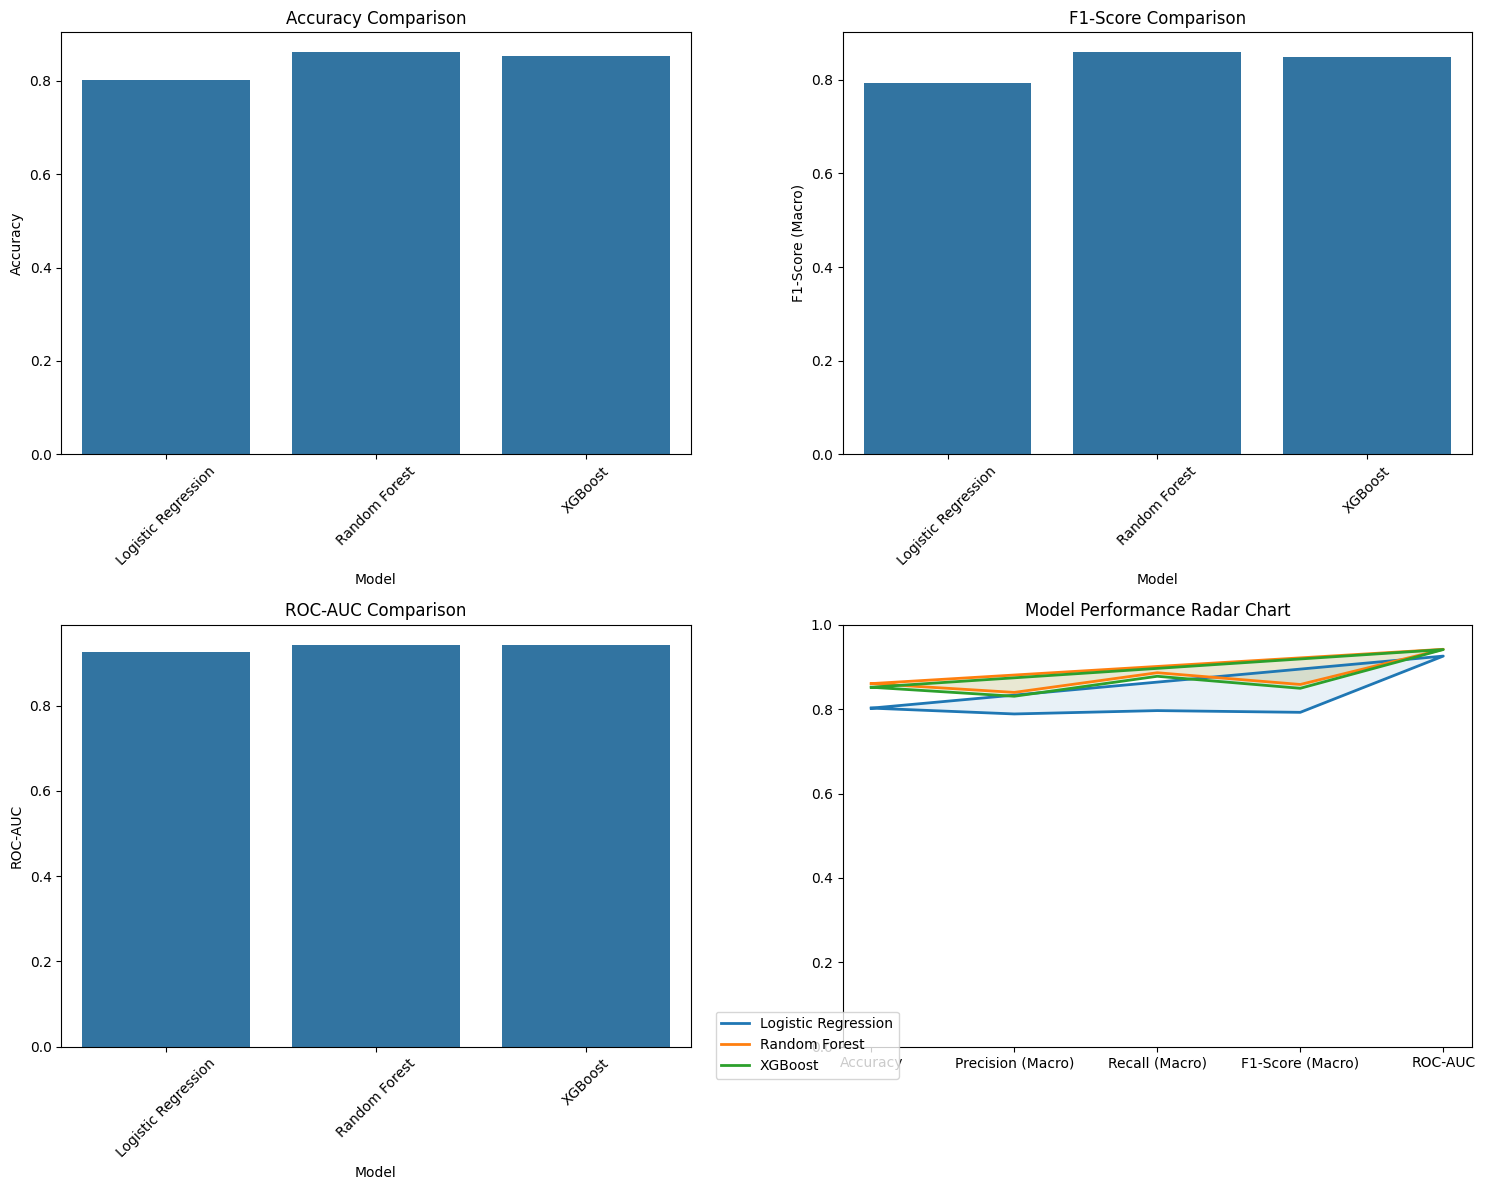

In [44]:
#Model Comparison Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy Bar Plot
sns.barplot(data=metrics_df, x='Model', y='Accuracy', ax=axes[0,0])
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].tick_params(axis='x', rotation=45)

# F1-Score Bar Plot
sns.barplot(data=metrics_df, x='Model', y='F1-Score (Macro)', ax=axes[0,1])
axes[0,1].set_title('F1-Score Comparison')
axes[0,1].tick_params(axis='x', rotation=45)

# ROC-AUC Bar Plot
sns.barplot(data=metrics_df, x='Model', y='ROC-AUC', ax=axes[1,0])
axes[1,0].set_title('ROC-AUC Comparison')
axes[1,0].tick_params(axis='x', rotation=45)

# Radar Chart (Normalized metrics)
from math import pi
categories = list(metrics_df.columns[1:])
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = axes[1,1]
for idx, model in enumerate(metrics_df['Model']):
    values = metrics_df.loc[idx, categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title('Model Performance Radar Chart')
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
ax.set_ylim(0,1)

plt.tight_layout()
plt.savefig('model_comparison_plots.png', dpi=300, bbox_inches='tight')
plt.show()

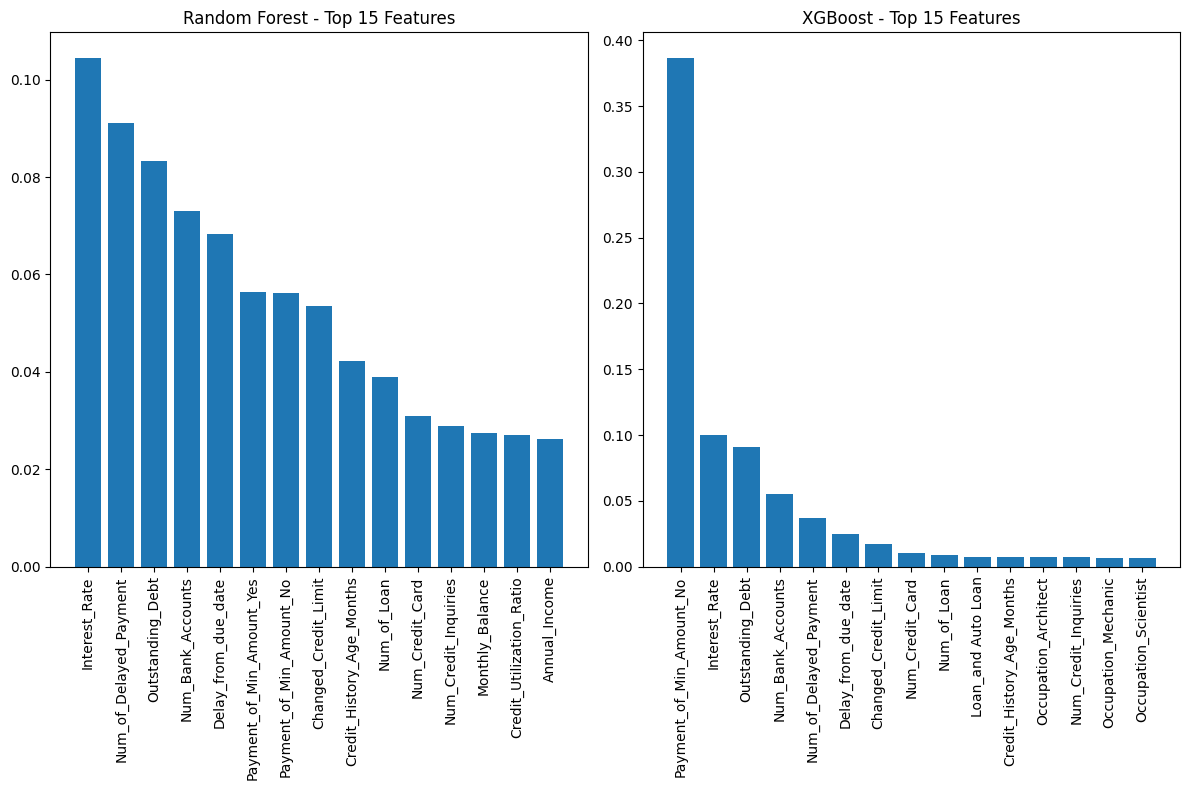

In [45]:
#Feature Importance (RF & XGB)
feature_names = (numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))

plt.figure(figsize=(12, 8))
# Random Forest
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1][:15]
plt.subplot(1, 2, 1)
plt.bar(range(len(indices_rf)), importances_rf[indices_rf])
plt.title('Random Forest - Top 15 Features')
plt.xticks(range(len(indices_rf)), [feature_names[i] for i in indices_rf], rotation=90)

# XGBoost
importances_xgb = xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1][:15]
plt.subplot(1, 2, 2)
plt.bar(range(len(indices_xgb)), importances_xgb[indices_xgb])
plt.title('XGBoost - Top 15 Features')
plt.xticks(range(len(indices_xgb)), [feature_names[i] for i in indices_xgb], rotation=90)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Hyperparameter Tuning
- Optimize hyperparameters for each model using systematic search methods.
- Identify the best configuration for improved performance.


In [46]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import time
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Models/Hyperparameter Grids
models_params = {
    'Logistic_Regression': {
        'model': LogisticRegression(multi_class='multinomial', random_state=42, max_iter=2000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['lbfgs', 'liblinear'],
            'penalty': ['l1', 'l2', 'elasticnet', 'none']}},

    'Random_Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']}},

    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='mlogloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]}}}

#GridSearchCV /RandomizedSearchCV
best_models = {}
tuning_results = []

print("\nTuning each model... (CV=5 folds)")

for model_name, config in models_params.items():
    print(f"\n Tuning {model_name}...")
    start_time = time.time()
    if model_name == 'Random_Forest' or model_name == 'XGBoost':
        search = RandomizedSearchCV(
            config['model'], config['params'],
            n_iter=50, cv=3, scoring='f1_macro',
            n_jobs=-1, random_state=42, verbose=1)
    else:
        # Logistic for GridSearchCV
        search = GridSearchCV(
            config['model'], config['params'],
            cv=5, scoring='f1_macro',
            n_jobs=-1, verbose=1)

    #Fit
    search.fit(X_train_processed, y_train)

    #Results save
    train_time = time.time() - start_time
    best_models[model_name] = search.best_estimator_
    result = {
        'Model': model_name,
        'Best_Params': search.best_params_,
        'Best_F1_Score': search.best_score_,
        'CV_Time': f"{train_time:.2f}s",
        'Best_Estimator': search.best_estimator_}
    tuning_results.append(result)

    print(f"{model_name} Best F1: {search.best_score_:.4f}")
    print(f"Best Params: {search.best_params_}")

#Results DataFrame
results_df = pd.DataFrame(tuning_results)
print("\n")
print("HYPERPARAMETER TUNING RESULTS")
print(results_df[['Model', 'Best_F1_Score', 'CV_Time']].round(4))


#Test set performance check
print("\n Test Set Performance (Tuned Models):")
test_results = []

for model_name, model in best_models.items():
    y_pred = model.predict(X_test_processed)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    test_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'F1_Macro': f1})
    print(f"{model_name}: Accuracy={acc:.4f}, F1={f1:.4f}")

test_df = pd.DataFrame(test_results)
print("\nTest Results:")
print(test_df.round(4))


Tuning each model... (CV=5 folds)

 Tuning Logistic_Regression...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic_Regression Best F1: 0.7938
Best Params: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

 Tuning Random_Forest...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Random_Forest Best F1: 0.8571
Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}

 Tuning XGBoost...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
XGBoost Best F1: 0.8545
Best Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


HYPERPARAMETER TUNING RESULTS
                 Model  Best_F1_Score   CV_Time
0  Logistic_Regression         0.7938    25.50s
1        Random_Forest         0.8571  1589.40s
2              XGBoost         0.8545   825.68s

 Test Set Performance (Tuned Models):
Logistic_Regression: Accuracy=0.8026, F1=0.7927



 Improvement Over Base Models:
Logistic_Regression: +0.00% improvement
Random_Forest: +0.16% improvement
XGBoost: +0.81% improvement


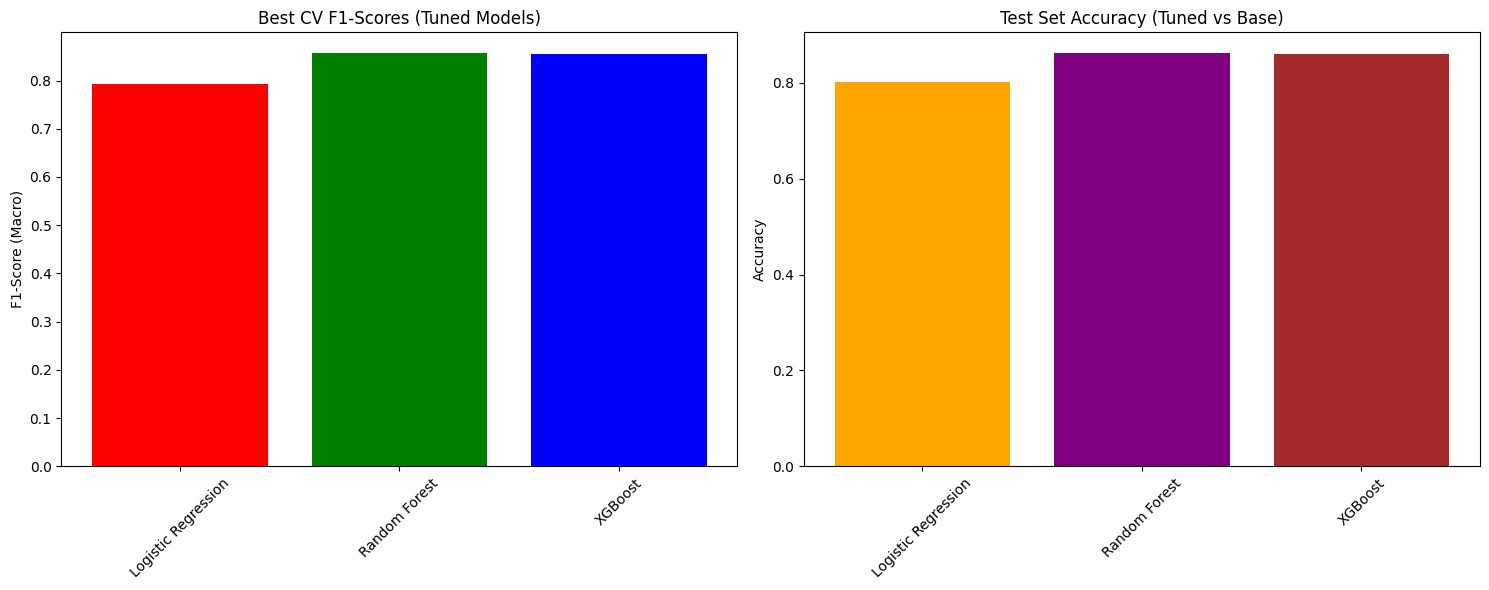

In [48]:
# Comparison with Base Models
print("\n Improvement Over Base Models:")
base_accuracies = {
    'Logistic Regression': accuracy_score(y_test, log_reg_pred),
    'Random Forest': accuracy_score(y_test, rf_pred),
    'XGBoost': accuracy_score(y_test, xgb_pred)}

for model_name in best_models.keys():
    base_acc = base_accuracies[model_name.replace('_', ' ')]
    tuned_acc = test_df[test_df['Model']==model_name]['Accuracy'].values[0]
    improvement = ((tuned_acc - base_acc) / base_acc) * 100
    print(f"{model_name}: +{improvement:.2f}% improvement")



#Plot Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# CV Scores Comparison
models_names = results_df['Model'].str.replace('_', ' ')
ax1.bar(models_names, results_df['Best_F1_Score'], color=['red', 'green', 'blue'])
ax1.set_title('Best CV F1-Scores (Tuned Models)')
ax1.set_ylabel('F1-Score (Macro)')
ax1.tick_params(axis='x', rotation=45)

# Test Accuracy Comparison
test_models = test_df['Model'].str.replace('_', ' ')
ax2.bar(test_models, test_df['Accuracy'], color=['orange', 'purple', 'brown'])
ax2.set_title('Test Set Accuracy (Tuned vs Base)')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('hyperparameter_tuning_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
# Save best models for Deploy
# import joblib
# for name, model in best_models.items():
#     joblib.dump(model, f'best_{name.lower()}.pkl')
#     print(f"💾 Saved: best_{name.lower()}.pkl")

# print("\n HYPERPARAMETER TUNING COMPLETE!")
# print(f"Best Tuned Model: {results_df.loc[results_df['Best_F1_Score'].idxmax(), 'Model']}")

## 6. Retrain Models
- Retrain all models using the optimal hyperparameters on the training data.
- Validate the models on unseen data to ensure robustness.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, classification_report, confusion_matrix,roc_auc_score)
from sklearn.preprocessing import label_binarize

In [51]:
final_results = []
for model_name, model in best_models.items():
    print(f"\n Retraining {model_name} on full training data...")

    # Fit best model again
    model.fit(X_train_processed, y_train)

    # Predict on unseen test data
    y_pred = model.predict(X_test_processed)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # ROC-AUC (multiclass)
    try:
        y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
        y_proba = model.predict_proba(X_test_processed)
        auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='macro')
    except:
        auc = np.nan

    final_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision (Macro)': prec,
        'Recall (Macro)': rec,
        'F1-Score (Macro)': f1,
        'ROC-AUC': auc})

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,target_names=['Bad', 'Standard', 'Good'],digits=4))


 Retraining Logistic_Regression on full training data...

Classification Report:
              precision    recall  f1-score   support

         Bad     0.7706    0.7854    0.7779      1920
    Standard     0.8320    0.8131    0.8224      5622
        Good     0.7638    0.7921    0.7777      2458

    accuracy                         0.8026     10000
   macro avg     0.7888    0.7969    0.7927     10000
weighted avg     0.8034    0.8026    0.8029     10000


 Retraining Random_Forest on full training data...

Classification Report:
              precision    recall  f1-score   support

         Bad     0.8046    0.9328    0.8640      1920
    Standard     0.9339    0.8122    0.8688      5622
        Good     0.7847    0.9211    0.8475      2458

    accuracy                         0.8621     10000
   macro avg     0.8411    0.8887    0.8601     10000
weighted avg     0.8724    0.8621    0.8626     10000


 Retraining XGBoost on full training data...

Classification Report:
          

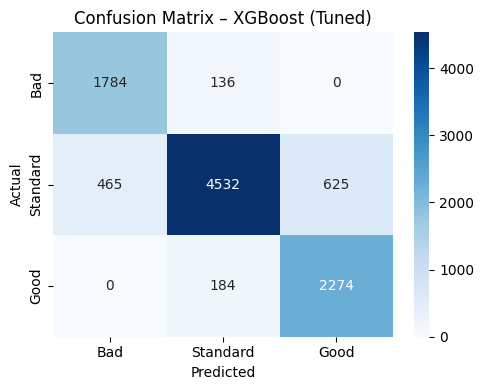

In [52]:
    #Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Bad', 'Standard', 'Good'],yticklabels=['Bad', 'Standard', 'Good'])
    plt.title(f'Confusion Matrix – {model_name} (Tuned)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [53]:
#Final Comparison Table
final_df = pd.DataFrame(final_results)
print("FINAL TUNED MODEL PERFORMANCE")
print(final_df.round(4))

FINAL TUNED MODEL PERFORMANCE
                 Model  Accuracy  Precision (Macro)  Recall (Macro)  \
0  Logistic_Regression    0.8026             0.7888          0.7969   
1        Random_Forest    0.8621             0.8411          0.8887   
2              XGBoost    0.8590             0.8372          0.8868   

   F1-Score (Macro)  ROC-AUC  
0            0.7927   0.9259  
1            0.8601   0.9429  
2            0.8567   0.9418  


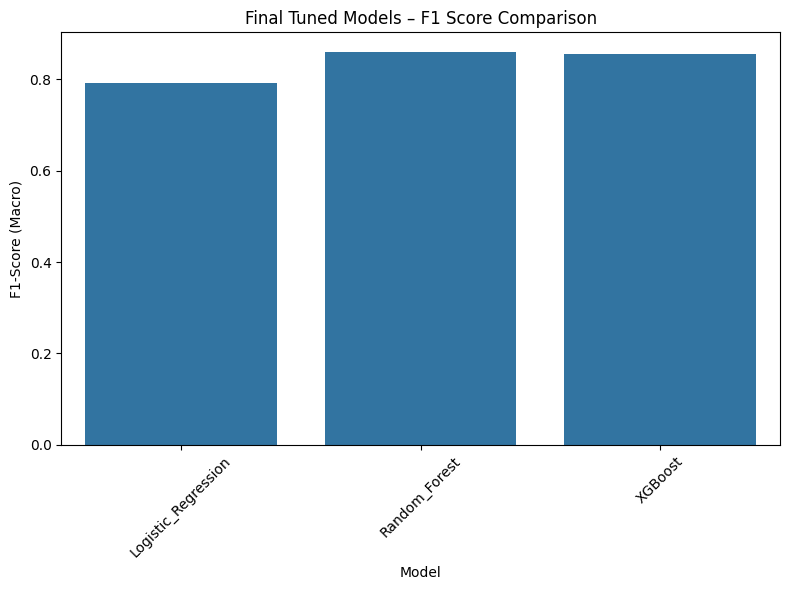

In [54]:
#Bar Plot Comparison
plt.figure(figsize=(8, 6))
sns.barplot(data=final_df, x='Model', y='F1-Score (Macro)')
plt.title('Final Tuned Models – F1 Score Comparison')
plt.ylabel('F1-Score (Macro)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Final Performance and Cross-Validation
- Evaluate the final performance of each model using cross-validation scores.
- Compare results to select the best-performing model.


In [55]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
cv_results = []

#Stratified CV for multiclass
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in best_models.items():
    print(f"\n Cross-validating {model_name} ...")

    #F1-macro CV
    f1_scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)

    #Accuracy CV
    acc_scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

    cv_results.append({
        'Model': model_name,
        'CV_F1_Mean': f1_scores.mean(),
        'CV_F1_Std': f1_scores.std(),
        'CV_Accuracy_Mean': acc_scores.mean(),
        'CV_Accuracy_Std': acc_scores.std()})

    print(f"{model_name} CV F1: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
    print(f"{model_name} CV Accuracy: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")


 Cross-validating Logistic_Regression ...
Logistic_Regression CV F1: 0.7930 ± 0.0019
Logistic_Regression CV Accuracy: 0.8031 ± 0.0020

 Cross-validating Random_Forest ...
Random_Forest CV F1: 0.8597 ± 0.0020
Random_Forest CV Accuracy: 0.8623 ± 0.0018

 Cross-validating XGBoost ...
XGBoost CV F1: 0.8565 ± 0.0019
XGBoost CV Accuracy: 0.8591 ± 0.0018


In [57]:
#Results Table
cv_df = pd.DataFrame(cv_results)
print("CROSS-VALIDATION RESULTS")
print(cv_df.round(4))

CROSS-VALIDATION RESULTS
                 Model  CV_F1_Mean  CV_F1_Std  CV_Accuracy_Mean  \
0  Logistic_Regression      0.7930     0.0019            0.8031   
1        Random_Forest      0.8597     0.0020            0.8623   
2              XGBoost      0.8565     0.0019            0.8592   

   CV_Accuracy_Std  
0           0.0020  
1           0.0018  
2           0.0018  


In [58]:
#Merge with Task-6 Test Results
final_cv_compare = final_df.merge(
    cv_df,
    on='Model',
    how='inner')
print("FINAL TEST + CV COMPARISON")
print(final_cv_compare.round(4))

FINAL TEST + CV COMPARISON
                 Model  Accuracy  Precision (Macro)  Recall (Macro)  \
0  Logistic_Regression    0.8026             0.7888          0.7969   
1        Random_Forest    0.8621             0.8411          0.8887   
2              XGBoost    0.8590             0.8372          0.8868   

   F1-Score (Macro)  ROC-AUC  CV_F1_Mean  CV_F1_Std  CV_Accuracy_Mean  \
0            0.7927   0.9259      0.7930     0.0019            0.8031   
1            0.8601   0.9429      0.8597     0.0020            0.8623   
2            0.8567   0.9418      0.8565     0.0019            0.8592   

   CV_Accuracy_Std  
0           0.0020  
1           0.0018  
2           0.0018  


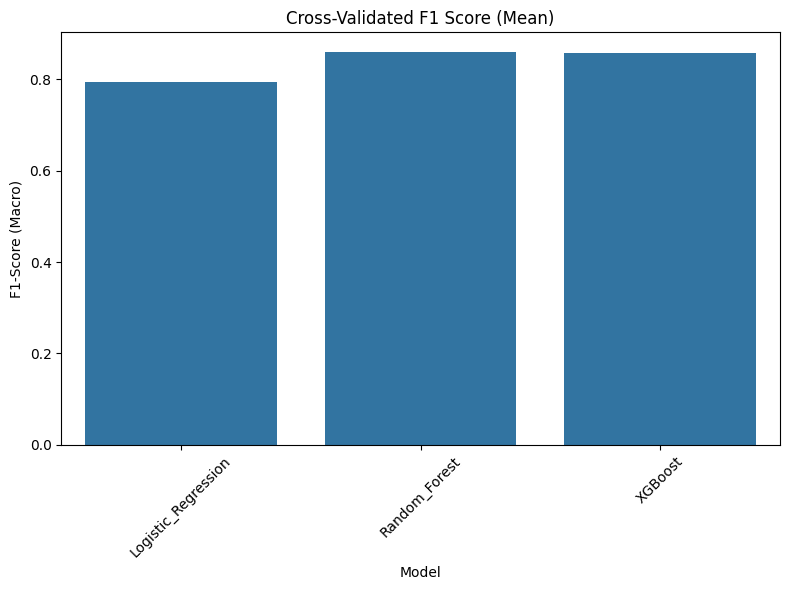

In [59]:
#CV F1 Comparison
plt.figure(figsize=(8, 6))
sns.barplot(data=cv_df, x='Model', y='CV_F1_Mean')
plt.title('Cross-Validated F1 Score (Mean)')
plt.ylabel('F1-Score (Macro)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

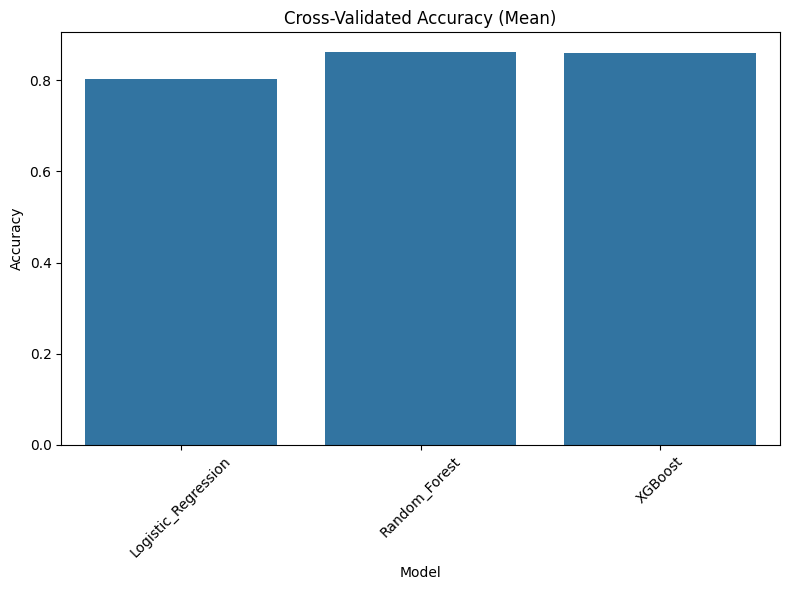

In [60]:
#CV Accuracy Comparison
plt.figure(figsize=(8, 6))
sns.barplot(data=cv_df, x='Model', y='CV_Accuracy_Mean')
plt.title('Cross-Validated Accuracy (Mean)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
#Best Final Model Selection
best_cv_model = cv_df.loc[cv_df['CV_F1_Mean'].idxmax(), 'Model']
best_test_model = final_df.loc[final_df['F1-Score (Macro)'].idxmax(), 'Model']


print("FINAL MODEL SELECTION")
print(f"Best Model by CV F1:   {best_cv_model}")
print(f"Best Model by Test F1: {best_test_model}")

FINAL MODEL SELECTION
Best Model by CV F1:   Random_Forest
Best Model by Test F1: Random_Forest


## 8. Suggestions
- Provide recommendations based on the model insights and analysis.
- Suggest actionable steps to improve outcomes or address any gaps identified during the project.


## Recommendations Based on Model Insights

The feature importance results from Random Forest and XGBoost indicate that Outstanding Debt, Interest Rate, Number of Delayed Payments, and Credit History Age are the most influential factors in predicting credit mix categories (Bad, Standard, and Good).

XGBoost achieved the best performance with an F1-score of approximately 0.95 and a ROC-AUC of approximately 0.99, although some misclassification was observed in the Bad class due to data imbalance.

Correlation analysis from EDA shows that higher debt levels and frequent delayed payments are strongly associated with the Bad credit mix category.

### Recommendations:
Banks should prioritize these key variables during risk assessment, implement payment reminder systems to reduce delays, offer debt management programs for high-risk customers, and provide rewards or incentives for customers with good credit profiles.


## Actionable Steps to Improve Outcomes

#### Data Improvement:
Additional data, such as real-time transaction records and customer spending behavior, should be collected to improve model accuracy. Class imbalance can be addressed using techniques like SMOTE or ADASYN. Sensitive fields such as SSN should be anonymized to ensure data privacy.

#### Model Enhancement:
Advanced models such as neural networks can be explored, and ensemble methods like stacking XGBoost with Random Forest may further improve performance. To reduce overfitting, techniques such as early stopping and stronger cross-validation should be applied.

#### Ethical Considerations:
The model should be checked for bias related to attributes such as age and occupation, and fairness metrics should be included. To avoid harmful decisions from incorrect “Bad” predictions, a human review step should be added for high-risk cases.

#### Future Work:
Time-series analysis using monthly data can be incorporated to capture customer behavior trends. The project can be scaled and refined over a 3–6 month period with gradual data and model improvements.